In [1]:
import pandas as pd

# Load the data
data = pd.read_csv('~/Desktop/BCI-Internship/HKM New DataAnalysis/Data/id_iskcon_data.csv', header=None)

# Display the first few rows of the dataframe
data.head()

,0,1,2,3,4,5
0,ID-001,NaN,NaN,Before,During,After
1,NaN,O1,NaN,NaN,NaN,NaN
2,NaN,NaN,Delta,183.617193,118.53653,98.654292
3,NaN,NaN,Theta,191.44795,157.525417,149.172204
4,NaN,NaN,Alpha,194.460529,118.560841,99.142915


In [2]:
# Clean and structure the data
cleaned_data = []
subject = None
location = None

for index, row in data.iterrows():
    if pd.notna(row[0]):
        subject = row[0]
    elif pd.notna(row[1]):
        location = row[1]
    elif pd.notna(row[2]):
        band = row[2]
        before = row[3]
        during = row[4]
        after = row[5]
        cleaned_data.append([subject, location, band, before, during, after])

# Convert to DataFrame
columns = ['Subject', 'Location', 'Band', 'Before', 'During', 'After']
df = pd.DataFrame(cleaned_data, columns=columns)

# Save cleaned data to a new CSV for reference
df.to_csv('cleaned_iskcon_data_cleaned.csv', index=False)
print(df.head())

  Subject Location   Band      Before      During       After
0  ID-001       O1  Delta  183.617193   118.53653   98.654292
1  ID-001       O1  Theta   191.44795  157.525417  149.172204
2  ID-001       O1  Alpha  194.460529  118.560841   99.142915
3  ID-001       O1   Beta  188.781926  118.269466   97.393877
4  ID-001       O1  Gamma   100.85645  103.850977    90.33118


In [3]:
df['Before'] = pd.to_numeric(df['Before'], errors='coerce')
df['During'] = pd.to_numeric(df['During'], errors='coerce')
df['After'] = pd.to_numeric(df['After'], errors='coerce')

print(df.dtypes)
print(df.head())

Subject      object
Location     object
Band         object
Before      float64
During      float64
After       float64
dtype: object
  Subject Location   Band      Before      During       After
0  ID-001       O1  Delta  183.617193  118.536530   98.654292
1  ID-001       O1  Theta  191.447950  157.525417  149.172204
2  ID-001       O1  Alpha  194.460529  118.560841   99.142915
3  ID-001       O1   Beta  188.781926  118.269466   97.393877
4  ID-001       O1  Gamma  100.856450  103.850977   90.331180


In [4]:
import pandas as pd
from scipy.stats import ttest_rel

def perform_ttests(data: pd.DataFrame, band: str) -> pd.DataFrame:
    """
    Perform paired t-tests for given band and return results in a DataFrame.

    Parameters:
    - data: DataFrame containing EEG data with columns 'Subject', 'Band', 'Before', 'During', 'After'.
    - band: The frequency band to analyze.

    Returns:
    - DataFrame with t-test results for each subject and comparison.
    """
    results = []
    for subject in data['Subject'].unique():
        subset = data[(data['Subject'] == subject) & (data['Band'] == band)]
        before = subset['Before'].values
        during = subset['During'].values
        after = subset['After'].values
        
        ttest_before_during = ttest_rel(before, during)
        ttest_during_after = ttest_rel(during, after)
        ttest_before_after = ttest_rel(before, after)
        
        results.append({
            'Subject': subject,
            'Comparison': 'Before-During',
            'Statistic': ttest_before_during.statistic,
            'p-value': ttest_before_during.pvalue
        })
        results.append({
            'Subject': subject,
            'Comparison': 'During-After',
            'Statistic': ttest_during_after.statistic,
            'p-value': ttest_during_after.pvalue
        })
        results.append({
            'Subject': subject,
            'Comparison': 'Before-After',
            'Statistic': ttest_before_after.statistic,
            'p-value': ttest_before_after.pvalue
        })
        
    return pd.DataFrame(results)

# Example: Perform t-tests for Delta band
ttest_results_df = perform_ttests(df, 'Delta')
print(ttest_results_df)

   Subject     Comparison  Statistic   p-value
0   ID-001  Before-During   0.813641  0.475428
1   ID-001   During-After   3.636435  0.035831
2   ID-001   Before-After   1.146039  0.334907
3   ID-003  Before-During   1.593557  0.209289
4   ID-003   During-After  14.156405  0.000764
5   ID-003   Before-After   1.960378  0.144799
6   ID-005  Before-During   2.693037  0.074223
7   ID-005   During-After  -5.250707  0.013453
8   ID-005   Before-After   1.823781  0.165694
9   ID-007  Before-During   1.855672  0.160518
10  ID-007   During-After   6.228689  0.008344
11  ID-007   Before-After   2.326811  0.102445
12  ID-013  Before-During   1.231157  0.305980
13  ID-013   During-After   1.106914  0.349112
14  ID-013   Before-After   1.292289  0.286797
15  ID-014  Before-During   2.907202  0.062138
16  ID-014   During-After   2.739778  0.071352
17  ID-014   Before-After   3.057268  0.055111
18  ID-016  Before-During   1.441157  0.245193
19  ID-016   During-After   4.154065  0.025359
20  ID-016   

/var/folders/6x/c19tq81j2954h_g4n73r3lp40000gn/T/ipykernel_24090/1776220615.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Comparison', y='p-value', data=subject_ttest_results, palette='viridis')


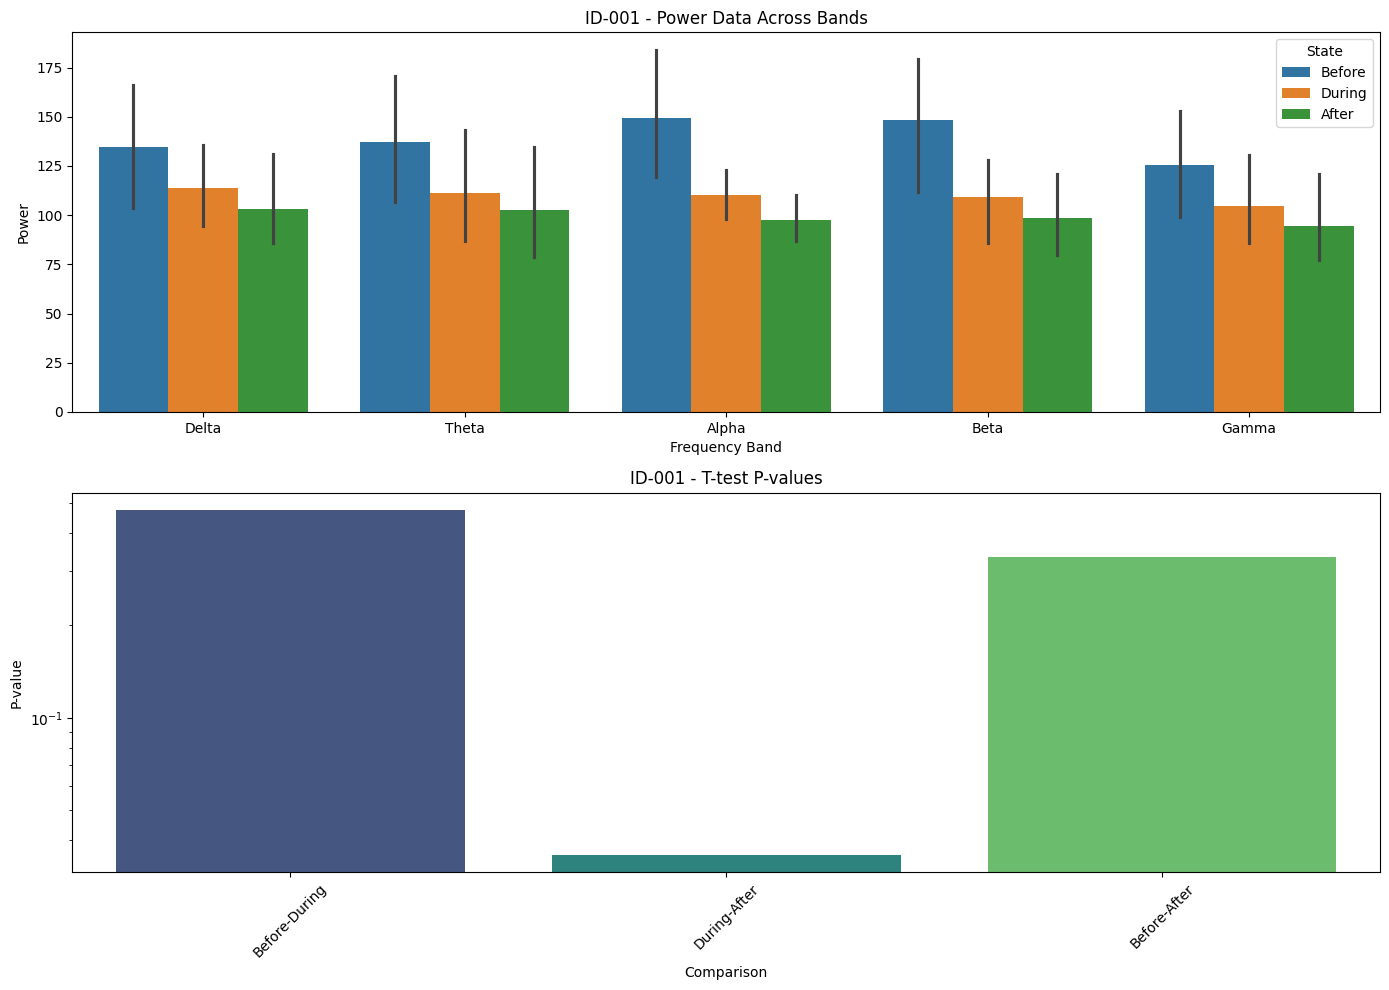

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_subject_data(data: pd.DataFrame, subject: str) -> None:
    """
    Plot power data and t-test results for a given subject.

    Parameters:
    - data: DataFrame containing EEG data with columns 'Subject', 'Band', 'Before', 'During', 'After'.
    - subject: The subject for which to plot data.
    """
    # Filter data for the subject
    subject_data = data[data['Subject'] == subject]

    # Plot Power Data
    plt.figure(figsize=(14, 10))

    # Power Plot
    plt.subplot(2, 1, 1)
    sns.barplot(x='Band', y='Value', hue='State', data=subject_data.melt(id_vars=['Band'], value_vars=['Before', 'During', 'After'], var_name='State', value_name='Value'))
    plt.title(f'{subject} - Power Data Across Bands')
    plt.ylabel('Power')
    plt.xlabel('Frequency Band')
    plt.legend(title='State')

    # Plot T-test Results
    ttest_results_df = perform_ttests(data, 'Delta')  # Assuming Delta band; adjust as needed
    subject_ttest_results = ttest_results_df[ttest_results_df['Subject'] == subject]

    plt.subplot(2, 1, 2)
    sns.barplot(x='Comparison', y='p-value', data=subject_ttest_results, palette='viridis')
    plt.title(f'{subject} - T-test P-values')
    plt.ylabel('P-value')
    plt.xlabel('Comparison')
    plt.yscale('log')  # Log scale for p-values
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Example usage
plot_subject_data(df, 'ID-001')


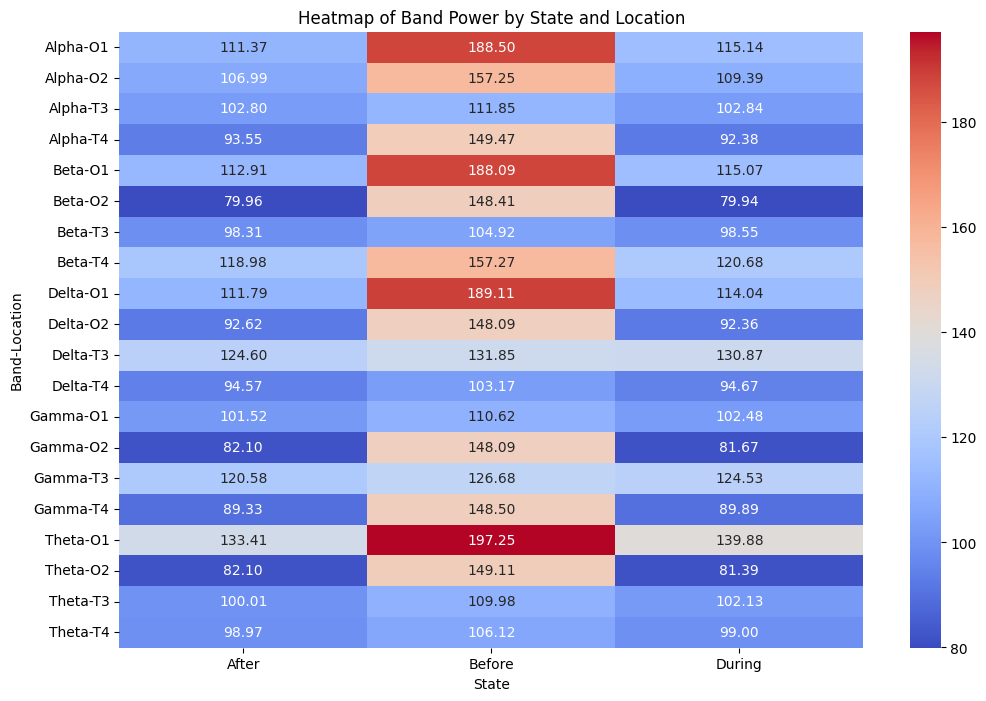

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_band_heatmap(data):
    # Reshape the DataFrame for seaborn
    melted = data.melt(id_vars=['Band', 'Location'], value_vars=['Before', 'During', 'After'], 
                       var_name='State', value_name='Power')
    
    # Pivot for heatmap
    heatmap_data = melted.pivot_table(index=['Band', 'Location'], columns='State', values='Power')
    
    # Create the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Heatmap of Band Power by State and Location')
    plt.show()

# Example: Plot band heatmap
plot_band_heatmap(df)


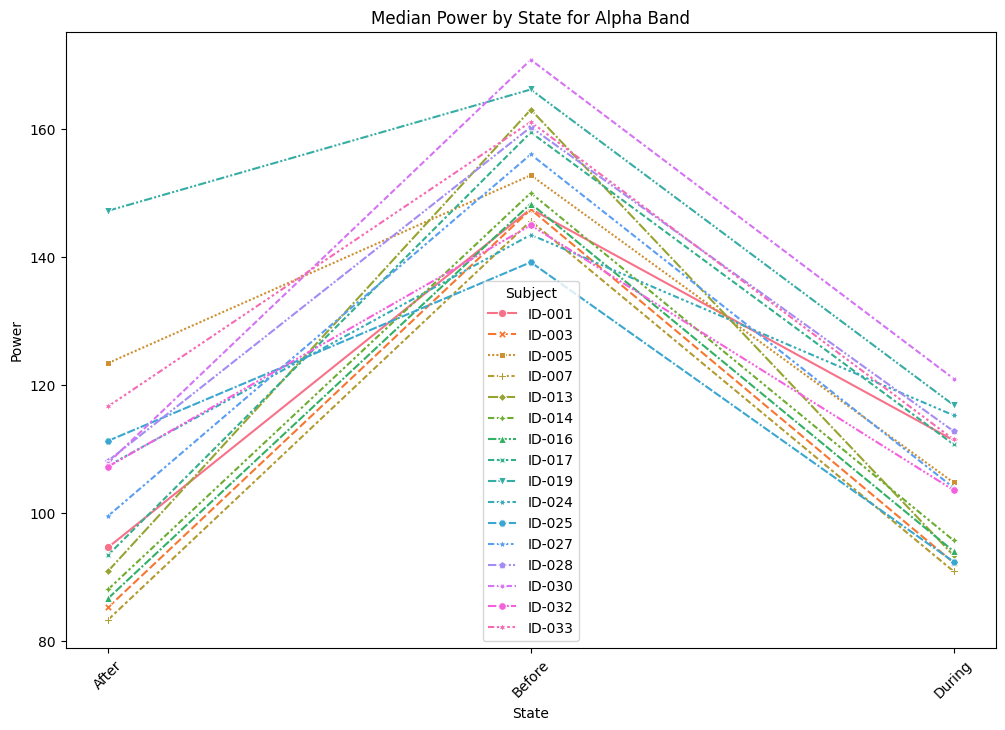

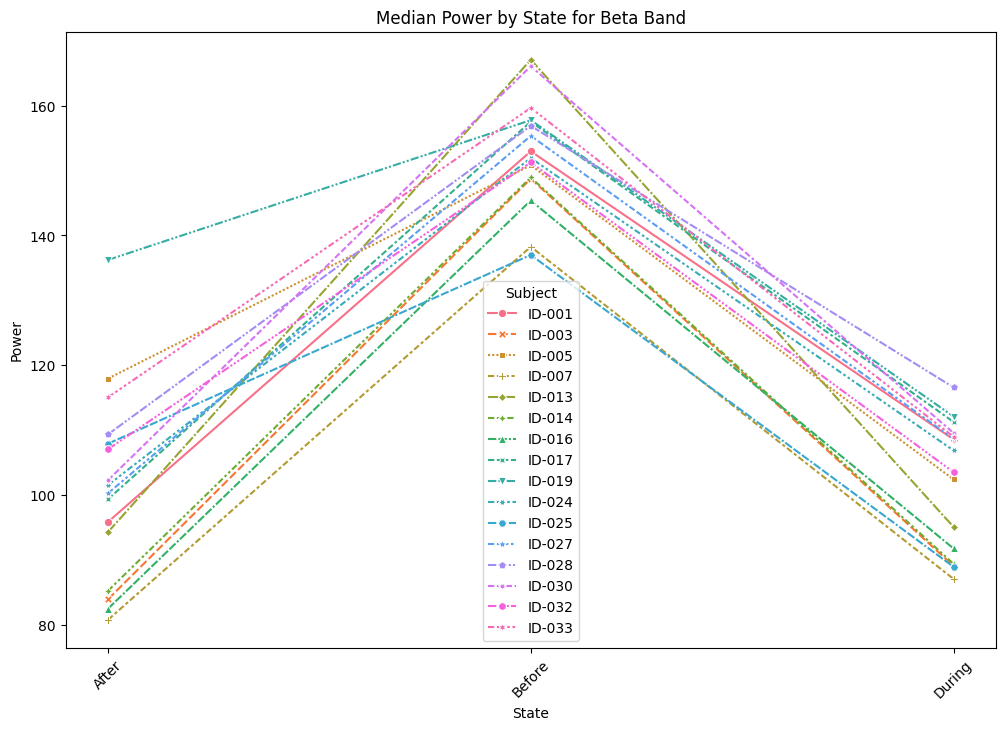

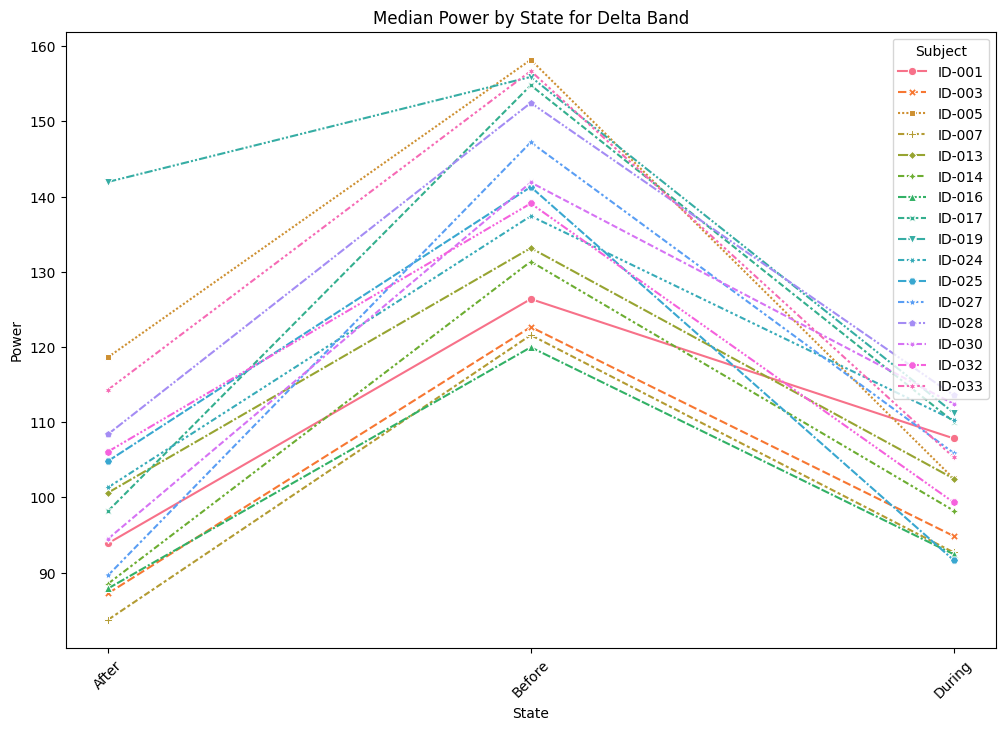

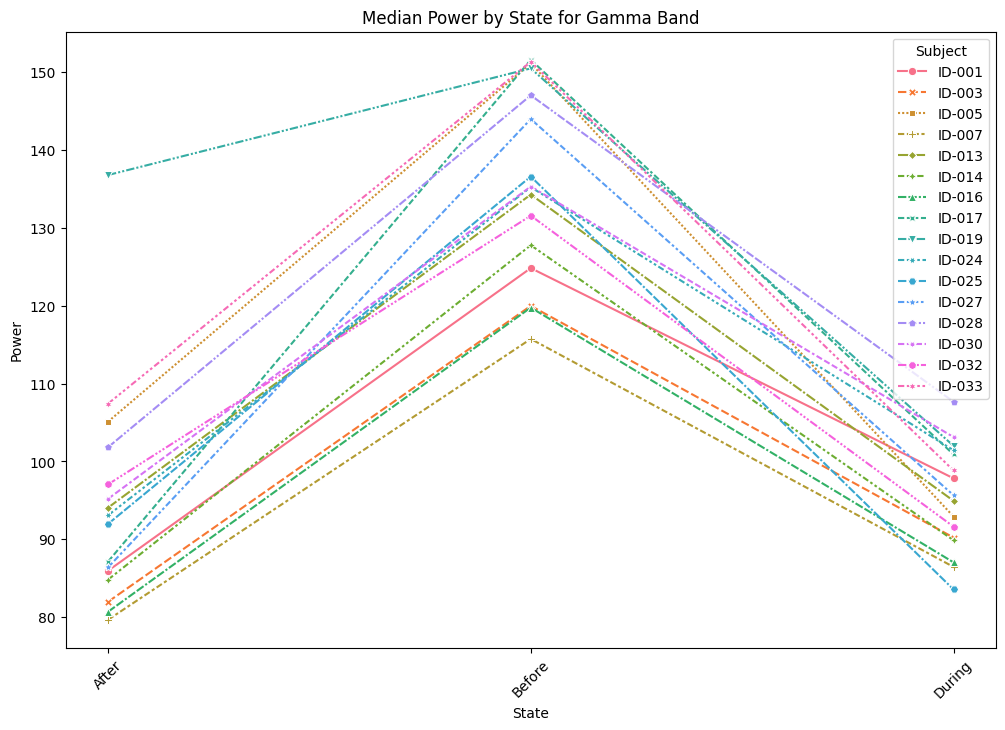

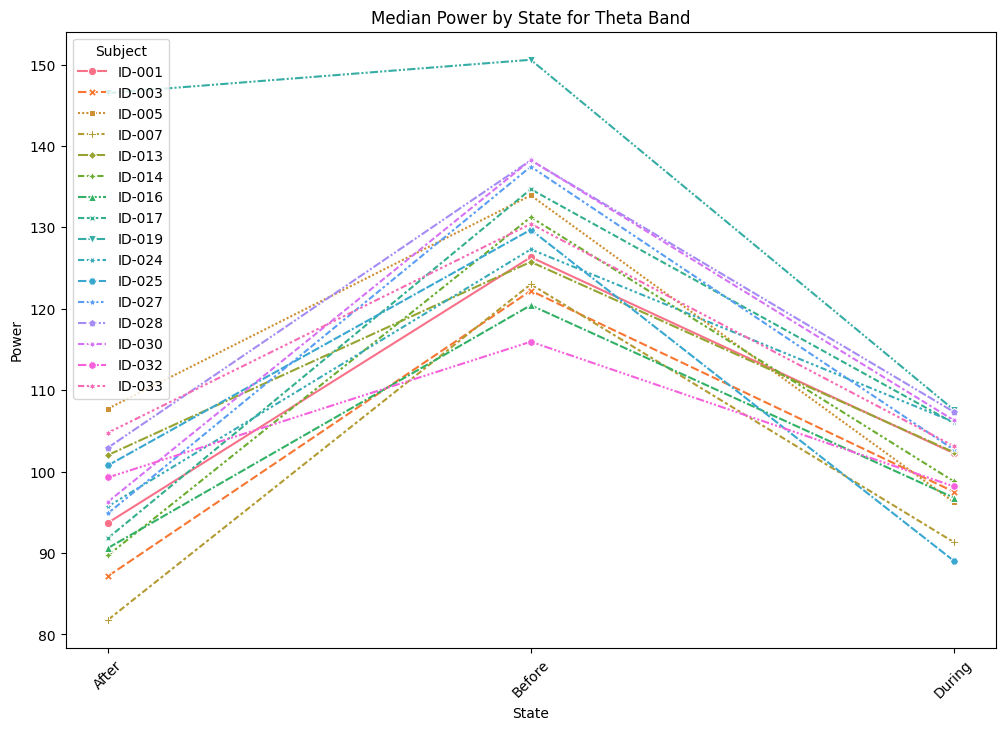

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_subject_summary(data):
    # Reshape the DataFrame for seaborn
    melted = data.melt(id_vars=['Subject', 'Band'], value_vars=['Before', 'During', 'After'], 
                       var_name='State', value_name='Power')
    
    # Calculate mean power for each subject, band, and state
    summary = melted.groupby(['Subject', 'Band', 'State']).agg({'Power': 'median'}).reset_index()
    
    # Get the unique bands
    bands = summary['Band'].unique()
    
    for band in bands:
        # Filter data for the current band
        band_data = summary[summary['Band'] == band]
        
        # Create the plot
        plt.figure(figsize=(12, 8))
        sns.lineplot(x='State', y='Power', hue='Subject', style='Subject', data=band_data, markers=True)
        plt.title(f'Median Power by State for {band} Band')
        plt.xticks(rotation=45)
        plt.legend(title='Subject')
        plt.show()

# Example: Plot subject summary
plot_subject_summary(df)

<Figure size 1200x1000 with 0 Axes>

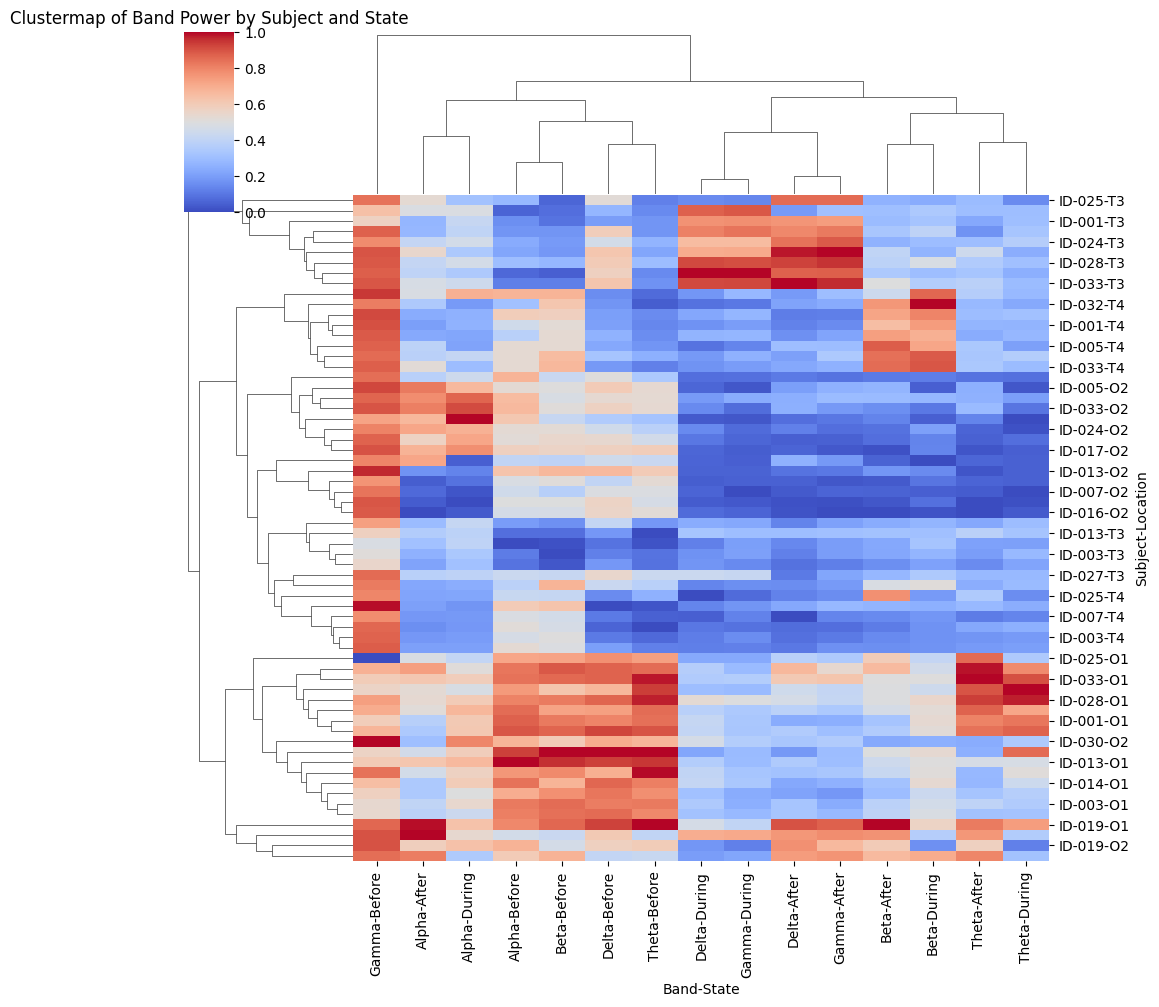

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_clustermap(data):
    # Reshape the DataFrame for the clustermap
    melted = data.melt(id_vars=['Subject', 'Band', 'Location'], value_vars=['Before', 'During', 'After'],
                       var_name='State', value_name='Power')
    
    # Pivot the data to have 'Subject' as rows, 'Band' as columns, and states as separate layers
    pivoted = melted.pivot_table(index=['Subject', 'Location'], columns=['Band', 'State'], values='Power')
    
    # Handle missing values: Fill NaNs with 0 or another appropriate value
    pivoted = pivoted.fillna(0)
    
    # Create the clustermap
    plt.figure(figsize=(12, 10))
    sns.clustermap(pivoted, cmap='coolwarm', annot=False, fmt='.2f', standard_scale=1)
    plt.title('Clustermap of Band Power by Subject and State')
    plt.show()

# Example: Plot clustermap
plot_clustermap(df)


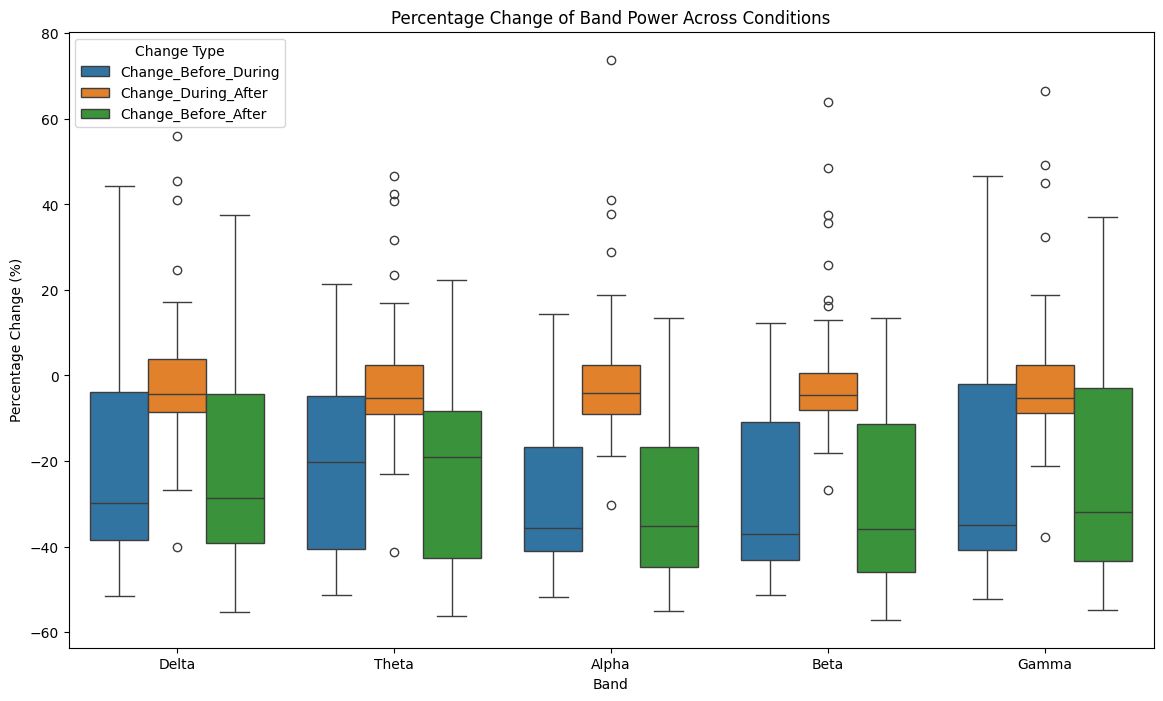

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_percentage_change(data):
    # Calculate percentage change for each subject, band, and location
    data['Change_Before_During'] = (data['During'] - data['Before']) / data['Before'] * 100
    data['Change_During_After'] = (data['After'] - data['During']) / data['During'] * 100
    data['Change_Before_After'] = (data['After'] - data['Before']) / data['Before'] * 100
    return data

def plot_percentage_changes(data):
    # Calculate percentage changes
    data = calculate_percentage_change(data)
    
    # Melt the DataFrame for easier plotting
    melted_data = pd.melt(data, id_vars=['Subject', 'Band', 'Location'], 
                          value_vars=['Change_Before_During', 'Change_During_After', 'Change_Before_After'],
                          var_name='Change_Type', value_name='Percentage_Change')
    
    # Plot percentage change for each condition
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Band', y='Percentage_Change', hue='Change_Type', data=melted_data)
    plt.title('Percentage Change of Band Power Across Conditions')
    plt.xlabel('Band')
    plt.ylabel('Percentage Change (%)')
    plt.legend(title='Change Type')
    plt.show()

# Example: Plot percentage changes for all subjects
plot_percentage_changes(df)


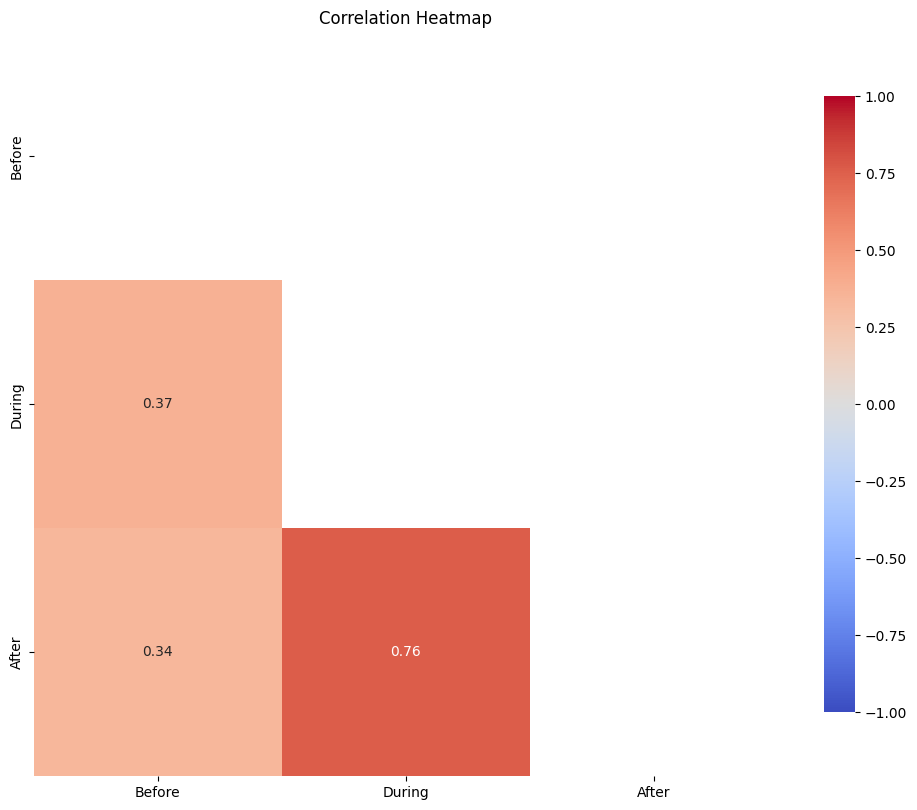

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def compute_correlation_matrix(data):
    # Drop rows with NaN values
    data = data.dropna()
    # Compute correlation matrix
    corr_matrix = data.corr()
    return corr_matrix

def plot_correlation_heatmap(corr_matrix):
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Set up the matplotlib figure
    plt.figure(figsize=(12, 10))
    
    # Draw the heatmap
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                cbar_kws={'shrink': .8}, vmin=-1, vmax=1, square=True)
    
    plt.title('Correlation Heatmap')
    plt.show()

# Example DataFrame: Replace with your actual data
data = df[['Before', 'During', 'After']]  # Replace with columns of interest

# Compute correlations and p-values
corr_matrix = compute_correlation_matrix(data)

# Plot the correlation heatmap
plot_correlation_heatmap(corr_matrix)